In [51]:
import os
from pathlib import Path
import calendar

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point, Polygon

import requests as rq

# for aWhere API
from header import AWhereAPI
from secret_codes import *

api_key = API_KEY
api_secret = API_SECRET

In [2]:
# Create aWhere object
aw = AWhereAPI(api_key, api_secret)

# To get auth token, encode secret and key
sc = aw.encode_secret_and_key(API_KEY, API_SECRET)

# Then call auth token
token = aw.get_oauth_token(sc)

In [3]:
# Set variables for aWhere API call 

# General endpoint
endpt = "https://api.awhere.com"

# Set up headers: auth and specific header for agronomics data
auth_headers = {"Authorization": "Bearer %s" % token,
                "Content-Type": 'application/json'}

agro_header = {"Authorization":  "Bearer %s" % token}

In [4]:
# Load area of interest into gpd

# Create path to home
home = str(Path.home())

# Create path to Siskiyou geojson since csv crashes Jupyter
path_to_josephine = os.path.join(
    home, "Desktop", "drought-tracker", "data", "TIGER", "josephine.geojson")

# Create df with 1 county (Siskiyou)
josephine = gpd.read_file(path_to_josephine)

# Convert into CRS
josephine = josephine.to_crs("EPSG:4236")

C:\Users\dphil\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [5]:
def create_awhere_grid(aoi, out_crs, calc_crs):
    """
    Parameters
    ----------
    aoi: Geopandas GeoDataFrame
        One-element GeoDataFrame containing area over which
        to draw grid
    
    out_crs: numeric string
        String of EPSG code for exported GDF
    
    calc_crs: numeric string
        String of EPSG code for CRS used
        to calculate grid. CRS must have units of meters
        to work with aWhere's API
        
    Returns
    -------
    GeoDataFrame containing 9km x 9km cells
    """   
    
    # Reproject aoi to CRS using meters for aWhere grid cells
    aoi = aoi.to_crs(f'EPSG:{calc_crs}')
    
    # Get x and y min and max from total boundaries
    xmin, ymin, xmax, ymax = aoi.total_bounds
    
    # Set side of grid cell to 9 km
    side = 9000
    
    # Create x values for x points for rows
    x_range = np.arange(int(np.floor(xmin)), int(np.ceil(xmax)), side)
    
    # Create y values
    y_range = np.arange(int(np.floor(ymin)), int(np.floor(ymax)), side)
    
    # Create empty list to hold grid cells
    polygons = []
    
    for x in x_range:
        for y in y_range:
            polygons.append(Polygon([(x,y), (x+side, y), (x+side, y+side), (x,y+side)]))
            
    grid = gpd.GeoDataFrame({'geometry': polygons}, crs=f"EPSG:{calc_crs}")
    
    #grid.set_crs = f'EPSG:{calc_crs}'
    
    # Convert to out_crs
    grid = grid.to_crs(f"EPSG:{out_crs}")
    
    return grid

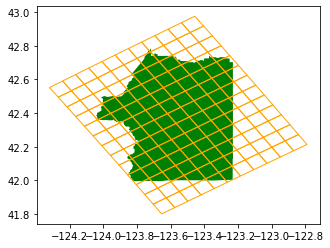

In [6]:
# Create grid polygon
grid = create_awhere_grid(aoi=josephine,
                          out_crs='4236',
                          calc_crs='2019')

# Add centroid column
grid['centroid'] = grid.geometry.apply(lambda poly: poly.centroid)

# Check to see if everything looks correct
fig, ax = plt.subplots()
grid.plot(color="none", linewidth=1, edgecolor='orange', ax=ax, zorder=3)
josephine.plot(color='green', zorder=2, ax=ax)

plt.show()

In [39]:
def call_api(lat, lon, start_date, end_date, testing=False):
    
        # URL to historical agronomics (norms)
        hist_ag_url = f"/v2/agronomics/locations/{lat},{lon}/agronomicvalues/{start_date},{end_date}"

        # Endpoint suffix to get all accumulations
        url_append = "?properties=accumulations"

        # Full URL, endpt is defined up top
        full_url = endpt + hist_ag_url + url_append
        
        if testing == False:
        
            # Get JSON
            ag_norms_json = rq.get(full_url, headers=agro_header).json()
            
            # Testing
            #print(ag_norms_json)
            
            return ag_norms_json
            
        elif testing == True:
            
            return full_url

In [41]:
def get_ppet(ppet_grid_df, start_date, end_date, drop_null=False, testing=False):
    """
    Paraemeters
    -----------
    grid_df: Geopandas GeoDataFrame
        Contains gridded area to fetch argonomics values for

    start_date: string
        Format "YYYY-MM-DD"

    end_date: string
        Format "YYYY-MM-DD"

    drop_null: boolean (optional)
        Drop grid cells that have null values returned from
        API request for agronomics data. Often null values 
        result from grid cell lying in a body of water.

    testing: boolean (optional)
        Returns sample P/PET values for each grid cell 
        from 0 - 30 mm. Used for testing; bypasses API call.

    Returns
    -------
    grid_df: Geopandas GeoDataFrame
        Contains gridded input area with requested values.

    """

    # Add P/PET column if it does not exist and set as float
    if 'ppet' not in ppet_grid_df.columns:
        ppet_grid_df = ppet_grid_df.assign(ppet=0.0)
        
    # For testing, generate random values for each cell
    if testing == True:
        ppet_grid_df['test_ppet'] = [np.random.randint(
            0, 30) for i in range(0, grid.shape[0])]

        return ppet_grid_df

    print("Calling API for each cell...")
    # Iterate thru rows (cells) in gdf
    for index, row in ppet_grid_df.iterrows():
        
        #Print progress
        #print(f"On row {index + 1} of {grid.shape[0]}")
        
        # Get centroid coordinates from each cell to pass to API
        lat = round(row.geometry.centroid.y, 5)
        lon = round(row.geometry.centroid.x, 5)

        # Get JSON using call_api function
        ag_norms_json = call_api(lat, lon, start_date, end_date)
        
        # Try to pull data from return JSON
        try:
            
            # Get "PPET" from JSON
            vals = ag_norms_json.get('accumulations').get('ppet')
            
            # Round result to 3 decimal places
            vals = round(vals, 3)
            
            # Add value to gdf
            ppet_grid_df.at[index, 'ppet'] = vals 
    
        except:
            
            ppet_grid_df.at[index, 'ppet'] = np.nan

        # Drop null cells if requested
        if drop_null == True:
            ppet_grid_df = ppet_grid_df[ppet_grid_df.ppet.isnull() == False]

    print("Grid with P/PET values generated.")
    
    return ppet_grid_df

In [9]:
ppet_grid_df = get_ppet(ppet_grid_df=grid,
                        start_date="2020-04-01",
                        end_date="2020-04-30",
                        drop_null=False,
                        testing=False)

Calling API for each cell...
Grid with P/PET values generated.


In [11]:
"""Add day range to this eventually"""
def binary_threshold(gdf, daily_acc_ppet_threshold, month=None, year=None):

    # Find monthly accumulated P/PET
    #days_in_month = calendar.monthrange(year, month)[1]

    # Calculate monthly accumulated P/PET based on user's threshold
    #monthly_acc_ppet = days_in_month * daily_acc_ppet_threshold
    monthly_acc_ppet = 30 * daily_acc_ppet_threshold

    # Add Boolean flag column if meets threshold
    gdf['meet_thresh'] = gdf['ppet'].apply(
        lambda x: 1 if x <= monthly_acc_ppet else 0)

    return gdf

In [16]:
binary_grid = binary_threshold(gdf=ppet_grid_df,
                               daily_acc_ppet_threshold=0.2,
                               month=4,
                               year=2020)

binary_grid[binary_grid.meet_thresh==1].count()

geometry       100
centroid       100
ppet           100
meet_thresh    100
dtype: int64

In [17]:
def to_convex_hull(gdf, crs):
    
    # Drop all rows that do not meet threshold
    meet_thresh_only = gdf[gdf.meet_thresh == 1]
    
    # Dissolve polygons that meet threshold
    meet_thresh_dissolve = meet_thresh_only.dissolve(by='meet_thresh')
    
    # Explode polygons so that there are unique contiguous areas
    exploded = meet_thresh_dissolve.explode()

    # Drop multi-index outer level generated from dissolve
    exploded = exploded.droplevel(0)
    
    # Get largest polygon
    largest = exploded[exploded.area == exploded.area.max()]
    
    # Generate convex hull
    hull_largest = largest.convex_hull

    # Convert to gdf
    hull = gpd.GeoDataFrame(hull_largest, crs=gdf.crs)

    # Rename column '0' to 'geometry'
    hull.rename(columns={0:"geometry"}, inplace=True)
    
    return hull

In [68]:
hull = to_convex_hull(binary_grid, 4326)

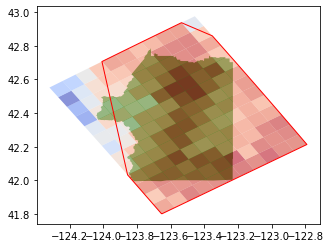

In [19]:
fig, ax = plt.subplots()

hull.plot(ax=ax, color='none', edgecolor='red', zorder=4)
binary_grid.plot(column='ppet', cmap='coolwarm_r', ax=ax, alpha=0.6, zorder=3)
josephine.plot(color='green', alpha=0.9, ax=ax)

plt.show()

In [83]:
def proportional_split(grid_gdf, hull_gdf, crs):
    
    grid_gdf = grid_gdf.to_crs(f"epsg:{crs}")
    
    hull_gdf = hull_gdf.to_crs(f"epsg:{crs}")
    
    # Set summary variables to 0
    inter_area_run_sum = 0
    
    # This is a list to more easily calculate average (using sum then len)
    inter_ppet_run_sum = []
    
    for index, row in grid_gdf.iterrows():
        
        if row.geometry.intersects(hull_gdf.geometry[0]):
            
            intersect_area = row.geometry.intersection(hull_gdf.geometry[0]).area
            
            # Find the proportional split of grid cell's P/PET
            proportional_ppet = (intersect_area / row.geometry.area) * row.ppet
            
            # Append it to the list
            inter_ppet_run_sum.append(proportional_ppet)
    
    # Find average P/PET per cell
    inter_ppet = round((sum(inter_ppet_run_sum) / len(inter_ppet_run_sum)), 3)
    
    # Find total droughted area
    droughted_area = hull_gdf.geometry[0].area
    
    #print(f"Average P/PET in droughted area: {inter_ppet}")
    
    #print(f"Total droughted area: {hull_gdf.geometry[0].area}")

    return inter_ppet, droughted_area
    
proportional_split(binary_grid, hull, "2019")

(4.352, 10043999999.999973)

In [96]:
start_year = 2018
end_year = 2019
start_day = "04-01"
end_day = "04-30"

# Calculate range of years
years_range = np.arange(start_year, end_year + 1)

# Create grid (does not change)
aoi_grid = create_awhere_grid(aoi=josephine,
                              out_crs='4236',
                              calc_crs='2019')

# Hold returned dfs for testing
hulls_list = []

# Hold returned P/PET values in convex hull
ppet_list = []

droughted_areas = []

for year in years_range:
    
    if year_grid_ppet is not None:
        year_grid_ppet.drop(year_grid_ppet.index, inplace=True)
    
    print(f"On year {year}.")

    # Add P/PET values to entire grid
    # Finctions calls API on centroid of each grid cell
    year_grid_ppet = get_ppet(ppet_grid_df=aoi_grid,
                              start_date=f"{year}-{start_day}",
                              end_date=f"{year}-{end_day}",
                              drop_null=False,
                              testing=False)

    # Reclassify grid using binary thresholding (1 = over threshold)
    year_binary_grid = binary_threshold(gdf=year_grid_ppet,
                                        daily_acc_ppet_threshold=3)

    # Generate convex hull
    year_convex_hull = to_convex_hull(year_binary_grid, 4326)
    
    hulls_list.append(year_convex_hull)
    
    # Proportional split
    # START HERE
    average_ppet, drought_area = proportional_split(year_binary_grid, hull, "2019")
    
    print(average_ppet, drought_area)

# create gdf from returned_data with idx = year, geom=convex_hull, data=proportional_split
gdf = gpd.GeoDataFrame(pd.concat(hulls_list, ignore_index=True))
gdf['year'] = years_range

# find centroids of hulls
# plot centroids

On year 2018.
Calling API for each cell...
Grid with P/PET values generated.
nan 10043999999.999973
On year 2019.
Calling API for each cell...
Grid with P/PET values generated.
nan 10043999999.999973
